Notes:
Client_id is not a user id. It is ID of the business who collected this specific data. Therefore there are only 4 of those clients

In [1]:
from __future__ import print_function

import os
import sys

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import matplotlib.ticker as mtick


PROJ_ROOT = os.path.join(os.pardir)
PATH=os.path.abspath(PROJ_ROOT)
#print(PATH)

In [2]:
#functions
def fill_NaN_between_two_columns(df, col1, col2):
    df[col1]= df[col1].fillna(df[col1].groupby(df[col2]).transform('first'))
    df[col2] = df[col2].fillna(df[col2].groupby(df[col1]).transform('first'))

def rows_to_del(df, column, kw_list):
    for kw in kw_list:
        rowstodel=df[df[column]==kw].index
        df.drop(rowstodel, inplace=True)

In [3]:
#creating df from json file and changing df['date'] to datetime type

df=pd.read_json('anon_transactions.json', orient='records')
df['date']=pd.to_datetime(df['date'], format='%Y-%m-%d')

df['date']

0       2020-08-20
1       2020-08-20
2       2020-08-20
3       2020-08-20
4       2020-08-20
           ...    
90081   2019-09-01
90082   2019-09-01
90083   2019-09-01
90084   2019-09-01
90085   2019-09-01
Name: date, Length: 90086, dtype: datetime64[ns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90086 entries, 0 to 90085
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   accountid             61386 non-null  float64       
 1   address               11940 non-null  object        
 2   amountnum             90086 non-null  float64       
 3   category              88891 non-null  object        
 4   categoryid            61386 non-null  float64       
 5   city                  28772 non-null  object        
 6   client_id             90086 non-null  object        
 7   country               85591 non-null  object        
 8   currency_code         61539 non-null  object        
 9   date                  90086 non-null  datetime64[ns]
 10  detail_category       58398 non-null  float64       
 11  high_level_category   60021 non-null  float64       
 12  latitude              11904 non-null  float64       
 13  longitude       

In [5]:
df.head() #There are 29 columns.

,accountid,address,amountnum,category,categoryid,city,client_id,country,currency_code,date,...,uid,zip_code,accountId,category0,finsight_api_uid,finsight_image,insight_ctaurl,insight_text,original_uid,tenant_id
0,10204036.0,None,300.00,Transfers,28.0,None,xUNKBjKaHyMto8AeLwVosyPv5jpWdSuK,US,USD,2020-08-20,...,UTaljsLsjma9nB3a3BgRtzfTvWK2,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10092333.0,None,60.00,Credit Card Payments,26.0,None,xUNKBjKaHyMto8AeLwVosyPv5jpWdSuK,US,USD,2020-08-20,...,MqWg0x97h9XwjSCFuxTrKok6JPC3,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10092333.0,None,9.13,Savings,40.0,None,xUNKBjKaHyMto8AeLwVosyPv5jpWdSuK,US,USD,2020-08-20,...,MqWg0x97h9XwjSCFuxTrKok6JPC3,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10092333.0,None,71.68,Transfers,28.0,None,xUNKBjKaHyMto8AeLwVosyPv5jpWdSuK,US,USD,2020-08-20,...,MqWg0x97h9XwjSCFuxTrKok6JPC3,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10092333.0,None,60.00,Credit Card Payments,26.0,None,xUNKBjKaHyMto8AeLwVosyPv5jpWdSuK,US,USD,2020-08-20,...,MqWg0x97h9XwjSCFuxTrKok6JPC3,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Wrangling

In [6]:
#Deleting columns of less significance:

df.drop(['client_id','currency_code','country','pending','original_description','category0','finsight_api_uid','finsight_image','insight_ctaurl','insight_text','original_uid','tenant_id','accountId'], axis=1,inplace=True)
# deleting [category0','finsight_api_uid','finsight_image','insight_ctaurl','insight_text','original_uid','tenant_id','accountId']
# deleting ['client_id',currency_code','country','pending','original_description']as these cols don't add much to the data. country==USA, currency==USD, Pending=1,0 and original_description=simple_description

In [7]:
df.info() #16 cols left

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90086 entries, 0 to 90085
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   accountid            61386 non-null  float64       
 1   address              11940 non-null  object        
 2   amountnum            90086 non-null  float64       
 3   category             88891 non-null  object        
 4   categoryid           61386 non-null  float64       
 5   city                 28772 non-null  object        
 6   date                 90086 non-null  datetime64[ns]
 7   detail_category      58398 non-null  float64       
 8   high_level_category  60021 non-null  float64       
 9   latitude             11904 non-null  float64       
 10  longitude            11904 non-null  float64       
 11  simple_description   89933 non-null  object        
 12  state                33293 non-null  object        
 13  transactionid        90086 non-

In [8]:
#currently zip_code shows 11800 non-null entries and city shows 28772 entries. 
## zip_code and city cols can be populated with information from each others respective rows. Therefore filling NaNs of each col with info from others


fill_NaN_between_two_columns(df, 'zip_code', 'city')

In [9]:
#currently category shows 88891 non-null entries and category_id shows 61386 entries. 
## category and category_id cols can be populated with information from each others respective rows. Therefore filling NaNs of each col with info from others


fill_NaN_between_two_columns(df, 'categoryid', 'category')

In [10]:
df.info() 
#after applying function fill_NaN_between_two_columns, 
#category column shows 89923 non-null entries and category_id shows 63174 entries
#And
#zip_code column shows 17970 non-null entries and city shows 28850 entries. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90086 entries, 0 to 90085
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   accountid            61386 non-null  float64       
 1   address              11940 non-null  object        
 2   amountnum            90086 non-null  float64       
 3   category             89923 non-null  object        
 4   categoryid           63174 non-null  float64       
 5   city                 28850 non-null  object        
 6   date                 90086 non-null  datetime64[ns]
 7   detail_category      58398 non-null  float64       
 8   high_level_category  60021 non-null  float64       
 9   latitude             11904 non-null  float64       
 10  longitude            11904 non-null  float64       
 11  simple_description   89933 non-null  object        
 12  state                33293 non-null  object        
 13  transactionid        90086 non-

In [11]:
#Category col needs to understood so we can keep the relevant data and del non significant data. 

In [12]:
df['category'].nunique() #66 unique categories in df (in original df)
#df['category'].unique()

66

In [13]:
kw_list=['Transfer','Transfers', 'Interest','Credit Card Payments','Uncategorized','Business Miscellaneous','Paychecks/Salary', 'Insurance', 'Savings', \
           'Other Income','Securities Trades','Deposits', 'Services','Tax','Taxes','Rent', \
           'Mortgages', 'Loans','Investment Income', 'ATM/Cash Withdrawals','Investment Income', 'Loans', 'Retirement Contributions',\
            'Expense Reimbursement', 'Retirement Income', 'Charitable Giving', 'Bank Fees', 'Wages Paid', 'Checks' ]
    
rows_to_del(df, 'category', kw_list)

#df['category'].nunique() #66 unique categories in df
df['category'].nunique() 

39

In [14]:
#Delete nan values in category col. 
rowstodel=df[df['category'].isnull()].index
df.drop(rowstodel, inplace=True)

In [15]:
df.info() #70130 rows left.Still have lots of NaN is several cols. #16 cols

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70130 entries, 5 to 90085
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   accountid            51335 non-null  float64       
 1   address              11640 non-null  object        
 2   amountnum            70130 non-null  float64       
 3   category             70130 non-null  object        
 4   categoryid           52884 non-null  float64       
 5   city                 27791 non-null  object        
 6   date                 70130 non-null  datetime64[ns]
 7   detail_category      49571 non-null  float64       
 8   high_level_category  49970 non-null  float64       
 9   latitude             11751 non-null  float64       
 10  longitude            11751 non-null  float64       
 11  simple_description   70130 non-null  object        
 12  state                31445 non-null  object        
 13  transactionid        70130 non-

In [16]:
df.describe()

,accountid,amountnum,categoryid,detail_category,high_level_category,latitude,longitude
count,5.133500e+04,70130.000000,52884.000000,49571.000000,4.997000e+04,11751.000000,11751.000000
mean,1.006016e+07,76.398858,25.198113,1241.904057,1.000001e+07,38.541507,-95.567847
std,5.704679e+04,415.882898,25.337271,165.673066,5.521852e+00,3.861017,13.468456
min,1.000912e+07,-810.250000,2.000000,1001.000000,1.000000e+07,6.166880,-157.920809
25%,1.003359e+07,9.440000,10.000000,1145.000000,1.000000e+07,35.276316,-105.101960
50%,1.004163e+07,21.440000,22.000000,1166.000000,1.000001e+07,39.986559,-96.841293
75%,1.007542e+07,53.030000,34.000000,1316.000000,1.000001e+07,40.169666,-84.228355
max,1.044931e+07,61000.000000,227.000000,1691.000000,1.000002e+07,64.849530,5.241890


In [17]:
#Dealing with rows that have <=0 amount (outliers) 

In [18]:
#Deleting rows that have -ve amount. Seems like those are refunds given to the customers
#Deleting rows that have 0 amount. I dont think these will help us build recomm system 

df[df.amountnum <=0].sort_values(by='category') #100 rows. Shows that these rows are from alot of categories

df[df.amountnum <=0]['category'].unique() #['Service Charges/Fees', 'Travel', 'Clothing/Shoes',
       #'Restaurants/Dining', 'Service', 'Food and Drink', 'Payment',
       #'Shops', 'Gasoline/Fuel', 'Healthcare/Medical', 'Groceries',
       #'General Merchandise', 'Other Expenses', 'Telephone Services',
       #'Gifts', 'Home Improvement', 'Dues and Subscriptions']

rowstodel=df[df.amountnum <=0].index
df.drop(rowstodel, inplace=True)


In [19]:
df.describe() 

,accountid,amountnum,categoryid,detail_category,high_level_category,latitude,longitude
count,5.126200e+04,70030.000000,52810.000000,49499.000000,4.989700e+04,11747.000000,11747.000000
mean,1.006012e+07,76.542794,25.198069,1241.916342,1.000001e+07,38.543145,-95.571648
std,5.695149e+04,416.147607,25.347277,165.677694,5.523870e+00,3.860654,13.469173
min,1.000912e+07,0.010000,2.000000,1001.000000,1.000000e+07,6.166880,-157.920809
25%,1.003359e+07,9.450000,10.000000,1145.000000,1.000000e+07,35.276316,-105.101960
50%,1.004163e+07,21.500000,22.000000,1166.000000,1.000001e+07,39.986559,-96.844270
75%,1.007542e+07,53.167500,34.000000,1316.000000,1.000001e+07,40.170583,-84.226951
max,1.044931e+07,61000.000000,227.000000,1691.000000,1.000002e+07,64.849530,5.241890


In [20]:
#Dealing with Outliers in amountnum

In [21]:
df[df.amountnum > 6000] 
#question for Ana: How should I deal with these values? Clearly majority of the items cost less than 
#$6000. Infact 75% of amountnums are < 53.167. Should I keep them as is or delete them?

##question for Ana: Have a look at "Home Maintenance" category. To me it looks like exact same amount has been charged to some customers and they paid to "royal swimming pool". 
#The uid for each of these rows looks different i.e different people paid "royal swiming pool" exact same amount... 
#I definitly think I can delete those. 

#question for Ana: On the same note: Other expenses category also doesn't make sense. There is one uid that has "other expense" three times for three 
#differnet amounts. There is one amount (the outlier in my view of 61000), also targetted as "other expense"


,accountid,address,amountnum,category,categoryid,city,date,detail_category,high_level_category,latitude,longitude,simple_description,state,transactionid,uid,zip_code
1023,10041633.0,None,9650.00,Cable/Satellite Services,15.0,NaN,2020-08-14,1156.0,10000004.0,NaN,NaN,"withdrawal * non-preprinted form($9,650.00)",None,49980663,0UIAYEH7qlUI6j1iiIg6XbmJWTG3,NaN
1695,10090574.0,None,10000.00,Refunds/Adjustments,227.0,NaN,2020-08-10,1188.0,10000019.0,NaN,NaN,refunds from charles schwab,None,49691898,qrM20C2QOIWFzE05oojmYGBuvZ03,NaN
3312,10082152.0,None,6440.20,Travel,23.0,NaN,2020-08-01,1663.0,10000011.0,NaN,NaN,delta air lines,None,14070232,Q55Xf6Tz8QbyWddyCwakQT9DH9n1,NaN
3467,10082152.0,None,6440.20,Travel,23.0,NaN,2020-07-30,1663.0,10000011.0,NaN,NaN,delta air lines,None,14039620,Q55Xf6Tz8QbyWddyCwakQT9DH9n1,NaN
3572,10041633.0,None,9000.00,Cable/Satellite Services,15.0,NaN,2020-07-29,1156.0,10000004.0,NaN,NaN,"withdrawal * non-preprinted form($9,000.00)",None,47069358,0UIAYEH7qlUI6j1iiIg6XbmJWTG3,NaN
12048,NaN,None,11000.00,Service,NaN,NaN,2020-07-22,NaN,NaN,NaN,NaN,affirm crb affirmdepo gary grande web id: 9400...,None,ddZ389Pr10uvNa5pk6bXudZbPR9DveUbbaeQL,1485894609577x971343875862658000,NaN
14420,NaN,None,24800.00,Service,NaN,NaN,2020-07-21,NaN,NaN,NaN,NaN,ach withdrawal / freedom financia ceo3068669 p...,None,XYvDgOkwrRSV83YxRaxNtgQNNy1oRwf43nB0r,1593304396039x470988776308397950,NaN
16908,NaN,None,7396.71,Service,NaN,NaN,2020-07-20,NaN,NaN,NaN,NaN,ach withdrawal / vanguard group 2321868841 ebt...,None,nY310eq9XaS0bO9mzymVUr0g38DnJkHA1X04P,1593304396039x470988776308397950,NaN
17237,NaN,None,20000.00,Service,NaN,NaN,2020-07-20,NaN,NaN,NaN,NaN,payment thank you-mobile,None,gw1zqeOApzcJr7dmBzYzcBNkjn5811Uqwz1wM,1497375447357x777552693616598800,NaN
22496,10082152.0,None,20000.00,Clothing/Shoes,5.0,NaN,2020-07-16,1527.0,10000010.0,NaN,NaN,group/events biltmorasheville nc xx0654,NC,13772201,Q55Xf6Tz8QbyWddyCwakQT9DH9n1,NaN


# PLOTS

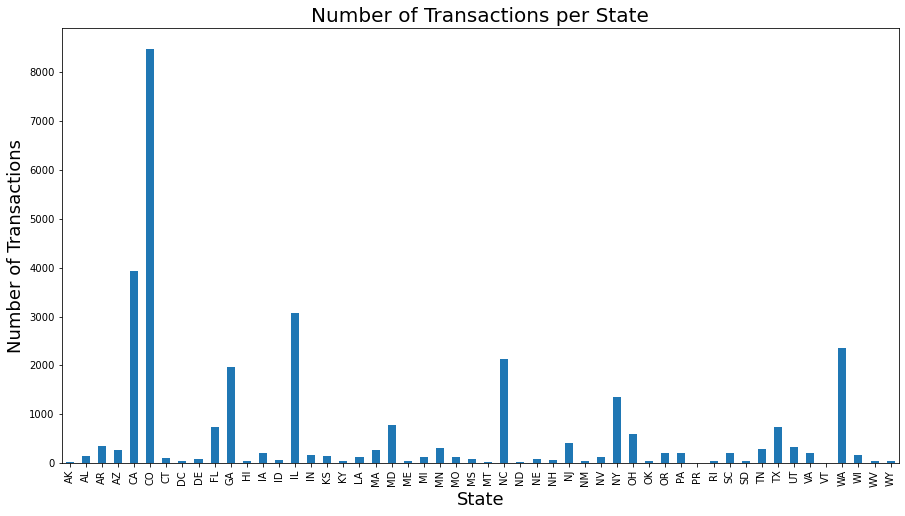

In [22]:
#records per state
df_state=df.groupby(['state'])['state'].count()
df_state.plot.bar(figsize=(15,8))

plt.title('Number of Transactions per State', fontsize=20)
plt.xlabel("State", fontsize=18)
plt.ylabel("Number of Transactions", fontsize=18)
plt.legend('', frameon=False)

#### Short commentary on above graph "Number of Transactions per State"

In [23]:
# From above graph: CO has the most records in this data, Next is CA, followed by IL, NC, WA, and NY. 
#All other states have considerably less number of records

In [24]:
#question for Ana: Can I delete following states as the data in these States is very small compared to others.
#AK, DC, DE, HI, ME, MT, NE, NH, NM, OK, RI, PR, SD, VT,WV, WY (number of records in these states are < 100)

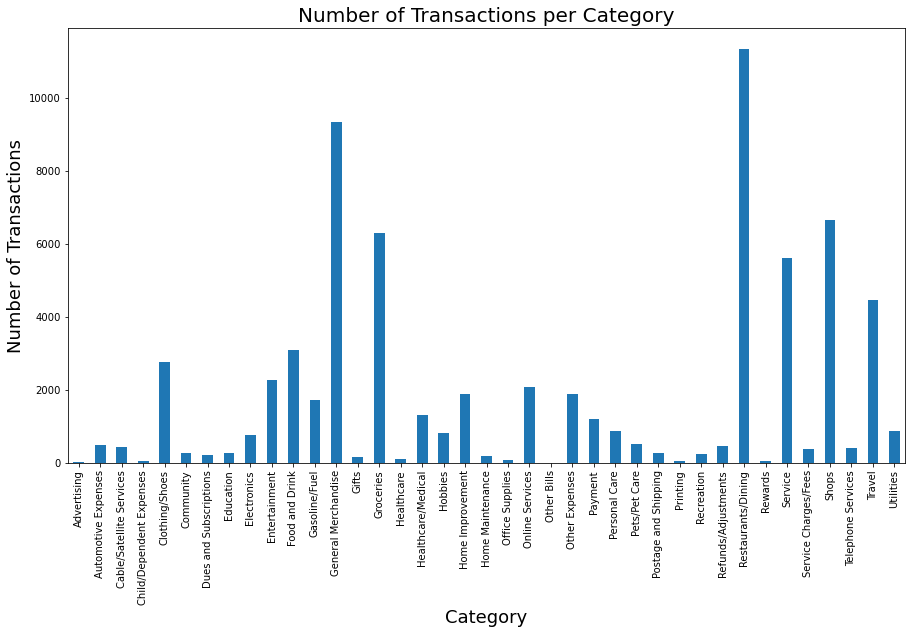

In [25]:
#Total number of records per category: 
df_cat=df.groupby(['category'])['category'].count()
df_cat.plot.bar(figsize=(15,8))

plt.title('Number of Transactions per Category', fontsize=20)
plt.xlabel("Category", fontsize=18)
plt.ylabel("Number of Transactions", fontsize=18)
plt.legend('', frameon=False)

#### Short commentary on above graph "Number of Transactions per Category"

In [26]:
## From above graph: the majority of records are coming from "Resturants/Dinning" Category.
## Followed by "General Merchandise", "Shops", "Groceries", "Service", "Travel". There are other categories even though 
## with less records could be significant in recommdation system

In [27]:
#question for Ana: Can I delete following categories as the data in these categories is very small compared to others.
#What could be consequence of deleting these?
#Advertising, Child/Dependent Expenses, HealthCare, Office Supplies, Other Bills, Printing, 

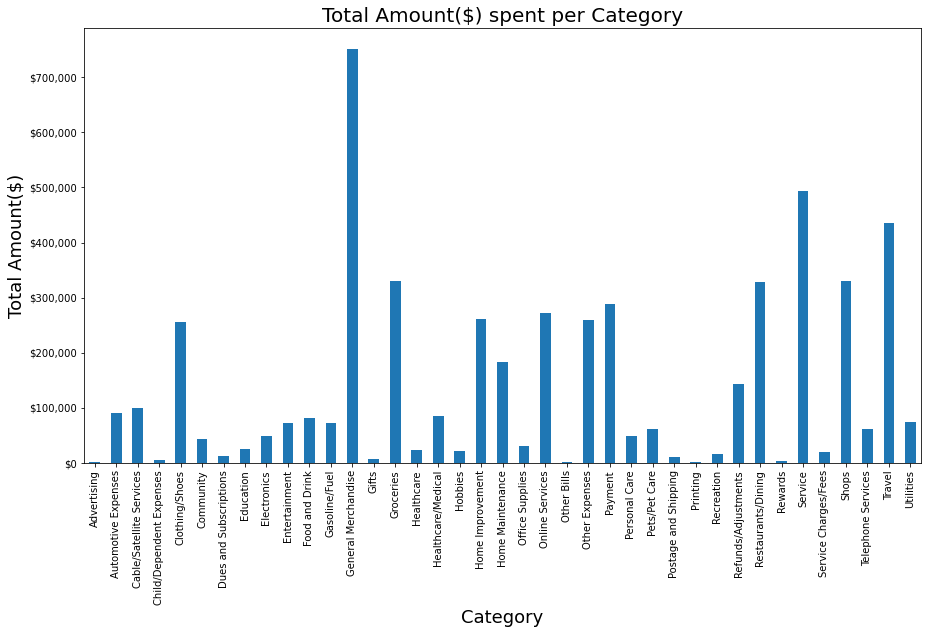

In [28]:
#Total amount spent per category
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

fmt = '${x:,.0f}'
df_amt_cat=df[['amountnum','category']].groupby('category').sum('amountnum')
df_amt_cat.plot.bar(ax=ax)


plt.title('Total Amount($) spent per Category', fontsize=20)
plt.xlabel("Category", fontsize=18)
plt.ylabel("Total Amount($)", fontsize=18)

tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

plt.legend('', frameon=False)

#df[['amountnum','category']].groupby('category').sum('amountnum').plot.bar()

#### Short commentary on above graph "Total Amount (\$\) Spent per Category"

In [29]:
#The category where most $ were spent is "General Merchandise". "Service", "Travel", 
#"Restuarants/Dinning", "Groceries" come next.
#There are a few categories that have almost zero amount spent. 
#question for Ana: Should I consider deleting rows per category where amount is significantly less?

In [30]:
#Plots with datetime obj

In [31]:
df_date=df[['date','amountnum']]
df_date

,date,amountnum
5,2020-08-20,20.63
8,2020-08-20,20.69
9,2020-08-20,28.51
10,2020-08-20,6.99
12,2020-08-20,1.09
...,...,...
90081,2019-09-01,5.36
90082,2019-09-01,16.00
90083,2019-09-01,31.68
90084,2019-09-01,6.05


In [32]:
df_date=df[['date','amountnum','category']].set_index('date')

In [33]:
s=df_date['amountnum']
s.index.normalize()

DatetimeIndex(['2020-08-20', '2020-08-20', '2020-08-20', '2020-08-20',
               '2020-08-20', '2020-08-20', '2020-08-20', '2020-08-20',
               '2020-08-20', '2020-08-20',
               ...
               '2019-09-01', '2019-09-01', '2019-09-01', '2019-09-01',
               '2019-09-01', '2019-09-01', '2019-09-01', '2019-09-01',
               '2019-09-01', '2019-09-01'],
              dtype='datetime64[ns]', name='date', length=70030, freq=None)

Text(0, 0.5, 'Mean Amount($)')

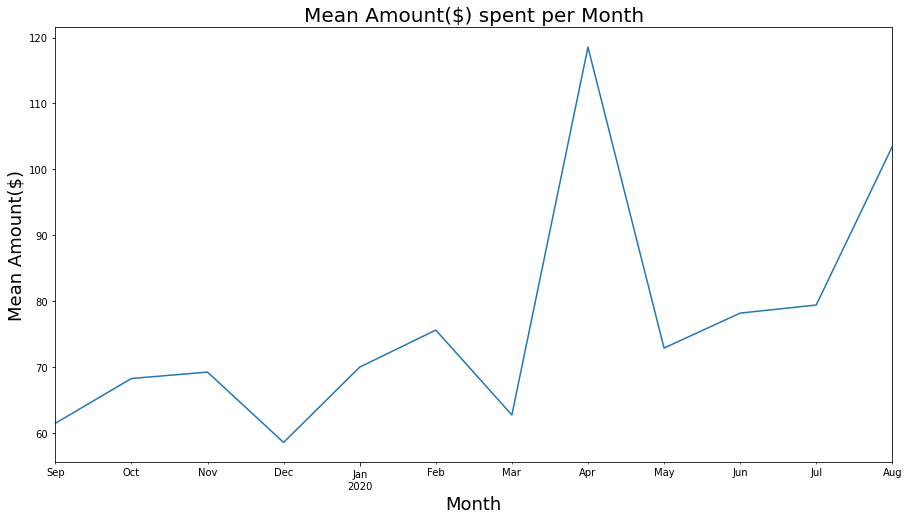

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

s.resample('M').mean().plot(ax=ax)

plt.title('Mean Amount($) spent per Month', fontsize=20)
plt.xlabel("Month", fontsize=18)
plt.ylabel("Mean Amount($)", fontsize=18)


#### Short commentary on above graph "Mean Amount Spent per Month"

In [75]:
## There is a significant spike in month of April. The april data is only from year 2020. Below is the mean amt per cat in April

In [84]:
#Mean amount per category in April 2020 in descending order
df_mean_Apr=df[pd.to_datetime(df['date']).dt.month == 4].groupby(['category']).mean('amountnum')['amountnum']
df_mean_Apr.sort_values(ascending=False)

category
Home Maintenance            5673.042174
Office Supplies             2831.910000
Refunds/Adjustments          935.930526
Travel                       231.357532
Automotive Expenses          210.770556
Other Expenses               203.928963
Telephone Services           162.624286
Education                    135.260000
Other Bills                  128.285000
Dues and Subscriptions       111.268696
Healthcare/Medical           106.393394
Home Improvement             101.069539
Gifts                         96.816316
Online Services               94.879701
Rewards                       83.468000
Cable/Satellite Services      80.829615
General Merchandise           80.499659
Groceries                     80.430020
Pets/Pet Care                 73.160490
Gasoline/Fuel                 65.882500
Utilities                     64.495000
Clothing/Shoes                62.729247
Service Charges/Fees          54.555128
Personal Care                 33.557857
Restaurants/Dining            2

Text(0, 0.5, 'Mean Amount($)')

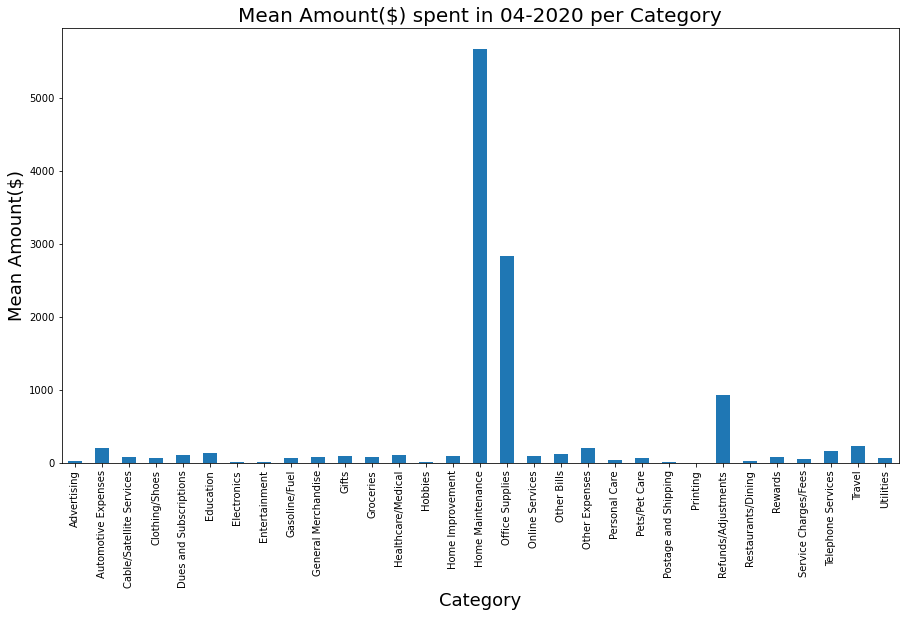

In [93]:
#Plot - Mean amount per category in April 2020
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
df_mean_Apr.plot.bar()

plt.title('Mean Amount($) spent in 04-2020 per Category', fontsize=20)
plt.xlabel("Category", fontsize=18)
plt.ylabel("Mean Amount($)", fontsize=18)

In [87]:
#Total amount per category in April 2020 in descending order

df_sum_Apr=df[pd.to_datetime(df['date']).dt.month == 4].groupby(['category']).sum('amountnum')['amountnum']
df_sum_Apr.sort_values(ascending=False)

category
Home Maintenance            130479.97
General Merchandise          78004.17
Groceries                    39732.43
Other Expenses               33444.35
Online Services              22201.85
Travel                       17814.53
Refunds/Adjustments          17782.68
Home Improvement             15362.57
Healthcare/Medical           11596.88
Restaurants/Dining           11544.41
Clothing/Shoes                9158.47
Pets/Pet Care                 7462.37
Gasoline/Fuel                 7115.31
Telephone Services            6830.22
Utilities                     6578.49
Office Supplies               5663.82
Automotive Expenses           3793.87
Entertainment                 3044.79
Dues and Subscriptions        2559.18
Service Charges/Fees          2127.65
Cable/Satellite Services      2101.57
Gifts                         1839.51
Hobbies                        819.63
Education                      811.56
Electronics                    601.72
Personal Care                  469.81
Rew

Text(0, 0.5, 'Total Amount($)')

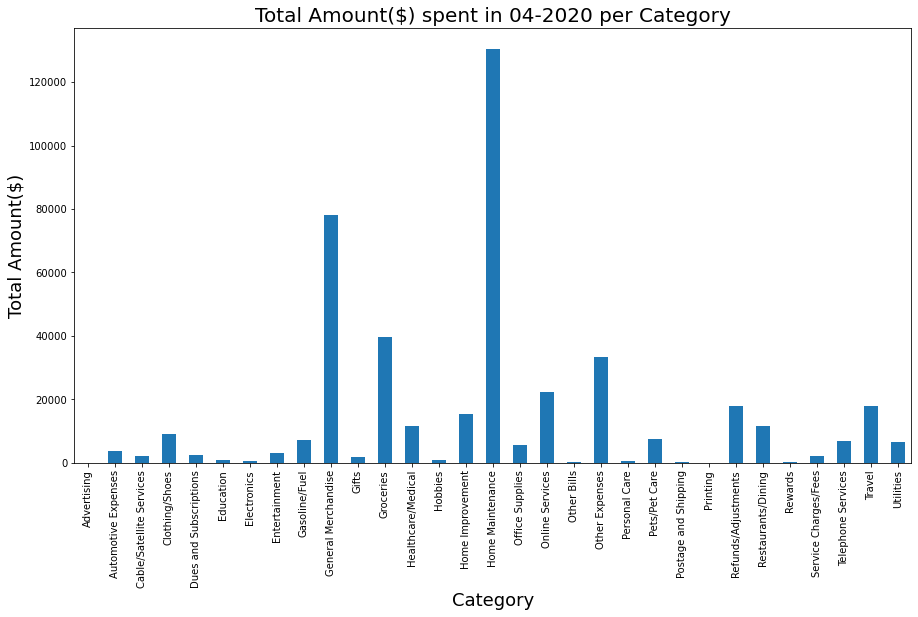

In [95]:
#Plot - Total amount per category in April 2020

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
df_sum_Apr.plot.bar()

plt.title('Total Amount($) spent in 04-2020 per Category', fontsize=20)
plt.xlabel("Category", fontsize=18)
plt.ylabel("Total Amount($)", fontsize=18)



In [91]:
df[(df.category=='Home Maintenance') & (df.date.dt.month==4)]

#Home Maintenance data looks weird. 20 records look exactly same except for diff transactionid, uid and accountid. 11 of those 20 have city=Memphis
#not sure what to make of this data 

,accountid,address,amountnum,category,categoryid,city,date,detail_category,high_level_category,latitude,longitude,simple_description,state,transactionid,uid,zip_code
49945,10010789.0,None,15.85,Home Maintenance,12.0,NaN,2020-04-29,1503.0,10000004.0,NaN,NaN,laco,CA,33664444,r6UyaCUrJvWTAHQTFdCQwbq0Vfq1,NaN
49955,10266274.0,None,6512.52,Home Maintenance,12.0,NaN,2020-04-29,1504.0,10000004.0,NaN,NaN,royal swimming pools,TN,13302192,IkLKMH96aua2iUSS3tObSr6TROb2,NaN
49959,10039738.0,None,6512.52,Home Maintenance,12.0,NaN,2020-04-29,1504.0,10000004.0,NaN,NaN,royal swimming pools,TN,12628786,QAAPzIoNW7VIc0rtuaMfobjlCMw1,NaN
49963,10073290.0,None,6512.52,Home Maintenance,12.0,NaN,2020-04-29,1504.0,10000004.0,NaN,NaN,royal swimming pools,TN,12624111,2TrwNEysErU8rKqlE73HCu1L5i23,NaN
49966,10018075.0,None,6512.52,Home Maintenance,12.0,NaN,2020-04-29,1504.0,10000004.0,NaN,NaN,royal swimming pools,TN,12621200,h4jqWSl4oNPRqHzt9F2c03W6y5p1,NaN
49968,10074469.0,None,6512.52,Home Maintenance,12.0,NaN,2020-04-29,1504.0,10000004.0,NaN,NaN,royal swimming pools,TN,12619565,hmyDYlFVOTdzIcTiiB2tjNTcki12,NaN
49971,10010788.0,None,6512.52,Home Maintenance,12.0,NaN,2020-04-29,1504.0,10000004.0,NaN,NaN,royal swimming pools,TN,12612843,5FrXFfLbAmNPPOOdXDWZ4ifaap82,NaN
49973,10073287.0,None,6512.52,Home Maintenance,12.0,NaN,2020-04-29,1504.0,10000004.0,NaN,NaN,royal swimming pools,TN,12612829,tpgEryFqqtSd5juhC85tim271ut2,NaN
49979,10033591.0,None,6512.52,Home Maintenance,12.0,NaN,2020-04-29,1504.0,10000004.0,NaN,NaN,royal swimming pools,TN,12611821,f3yb4bYIIFWYItHI5b3wSF4vbX22,NaN
49981,10094468.0,None,6512.52,Home Maintenance,12.0,NaN,2020-04-29,1504.0,10000004.0,NaN,NaN,royal swimming pools,TN,12611748,O6tyCkN6SBh2H54ogwIiKYspjkN2,NaN
